
<class 'nibabel.nifti1.Nifti1Image'>
data shape (74, 98, 44)
affine:
[[0.92773402 0.         0.         0.92773402]
 [0.         0.92773402 0.         0.92773402]
 [0.         0.         1.5        1.5       ]
 [0.         0.         0.         1.        ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [ 3 74 98 44  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [1.       0.927734 0.927734 1.5      1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax         

Text(0.5, 0.98, 'Center slices for EPI image')

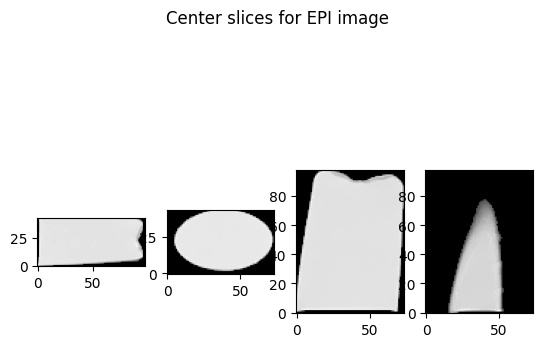

In [59]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

nii_object = nib.load('Data/I004_3.nii.gz')
nii_data = nii_object.get_fdata()

print(nii_object)
print(nii_data)

def show_slices(slices):
    fig, axes = plt.subplots(1,len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

slice_0 = nii_data[int(nii_data.shape[0]/2), :, :]
slice_1 = nii_data[:,int(nii_data.shape[1]/2), :]
slice_2 = nii_data[:, :, int(nii_data.shape[2]/2)]
slice_3 = nii_data[:,:,3]
show_slices([slice_0, slice_1, slice_2,slice_3])
plt.suptitle("Center slices for EPI image")




In [53]:
import os
import numpy as np
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


def read(path):
    scan = nib.load(path)
    scan.get_fdata(path)
    return scan

# normalizing the volume between the ranges of [-1000,1000]
def normalize(volume):
    min = -1000
    max = 1000
    if volume < min:
        volume = min
    elif volume > max:
        volume = max
    return volume 

# to lower computational cost, resize the 3D image across the z axis
def resize(img):
    
    setDepth = 64
    setWidth = 128
    setHeight = 128

    currentDepth = img.shape[2]
    currentWidth = img.shape[1]
    currentHeight = img.shape[0]

    d = currentDepth / setDepth
    w = currentWidth / setWidth
    h  = currentHeight / setHeight

    depthFactor = 1 / d 
    widthFactor = 1 / w 
    heightFactor = 1 / h

    img = ndimage.rotate(img, 90, reshape= False)
    img  = ndimage.zoom (img, (widthFactor, heightFactor, depthFactor), order=1)

    return img


def process_img(path):
    volume = read(path)
    volume = normalize(volume)
    volume = resize(volume)
    return volume 



0.0
1381.0
1072.0
